# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

First load the libaries:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, feature_selection, model_selection,metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

%matplotlib inline

# Load Datasets and Data Cleaning

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

**Load the three json files**

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## The portfolio dataset

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Rename id to offer_id for later table join, and convert channels to four coloumns**

In [4]:
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


**Drop the original channels column**

In [5]:
portfolio.drop('channels',axis=1,inplace=True)
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## The profile dataset

In [6]:
profile.shape

(17000, 5)

In [7]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**rename id in profile as customer_id for later table join**

In [8]:
profile.rename(columns = {'id':'customer_id'}, inplace=True)

**check the fraction of null values in each fields**

In [9]:
profile.isnull().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
customer_id         0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

**checking duplicates in profile**

In [10]:
profile.columns.duplicated().sum()

0

**plot the age distribution**

One can see the outlier age with a value of 118

<AxesSubplot:>

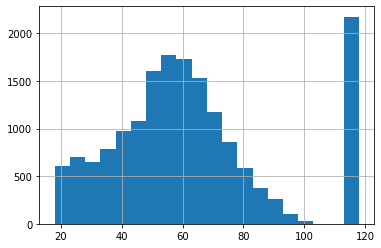

In [11]:
profile.age.hist(bins=20)

**how many data points have age = 118?**

In [12]:
print("how many data points have age = 118:", profile[profile.age==118].shape[0])
print("The fraction of data points with age = 118:", profile[profile.age==118].shape[0]/profile.shape[0])

how many data points have age = 118: 2175
The fraction of data points with age = 118: 0.12794117647058822


**The age=118 data points exactly match gender and income with missing values:**

In [13]:
print(profile[profile.age==118].gender.unique())
print(profile[profile.age==118].income.unique())

[None]
[nan]


**Distribution and counts of gender**

In [14]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

<AxesSubplot:>

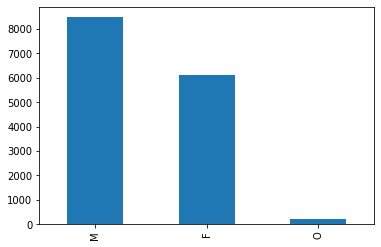

In [15]:
profile['gender'].value_counts().plot(kind='bar', stacked=True)

**Count the total # of customer id in profile**

In [16]:
profile['customer_id'].nunique()

17000

**Plot the income distribution, and the income distribution seperated by two genders**

<AxesSubplot:>

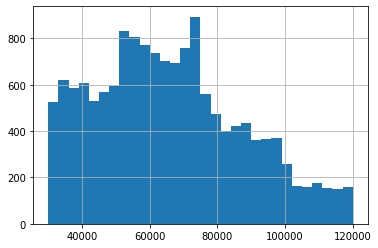

In [17]:
profile['income'].hist(bins=30)

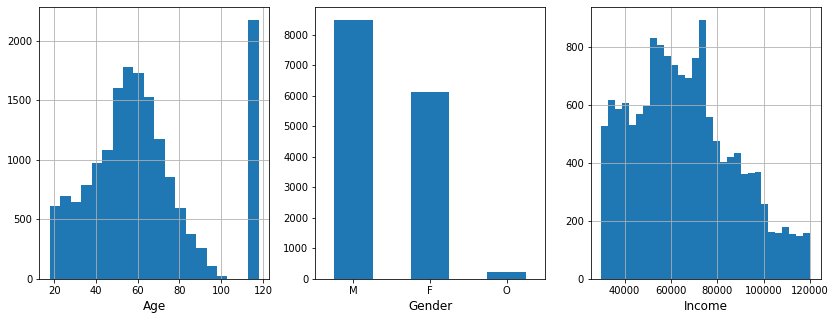

In [18]:
# Plot the above three figures together

fig, ax = plt.subplots(1, 3,figsize=(14,5))

profile.age.hist(ax = ax[0], bins=20)
profile['gender'].value_counts().plot(ax = ax[1], kind='bar', stacked=True, rot=0)
profile['income'].hist(ax = ax[2], bins=30)

ax[0].set_xlabel('Age', fontsize=12)
ax[1].set_xlabel('Gender', fontsize=12)
ax[2].set_xlabel('Income', fontsize=12)

fig.show()

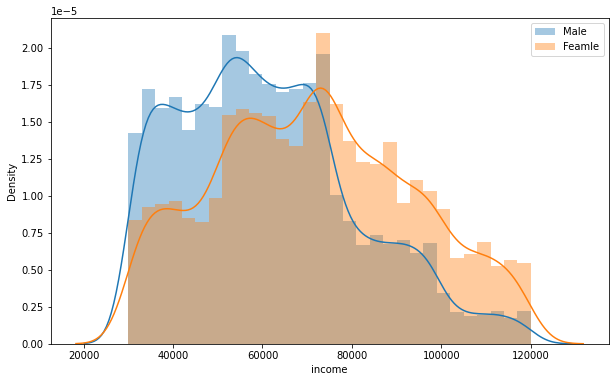

In [19]:
# Income distribution for two genders

income_m = profile[profile.gender == 'M'].income
income_f = profile[profile.gender == 'F'].income

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(income_m, bins=30, label='Male',ax=ax)
sns.distplot(income_f, bins=30, label='Feamle',ax=ax)
ax.legend()
plt.show()

## The transcript dataset

In [20]:
transcript.shape

(306534, 4)

In [21]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Rename person to customer_id**

In [22]:
transcript.rename(columns={'person':'customer_id'},inplace=True)

**Check duplicates in transcript**

In [23]:
transcript.columns.duplicated().sum()

0

**Check missing values in transcript**

In [24]:
transcript.isnull().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

**count different events in transcript**

There are four types of events:

- offer received
- offer viewed
- transaction
- offer completed

In [25]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**Count the total # of customer ids in transcript: same as in profile**

In [26]:
transcript.customer_id.nunique()

17000

**Explore the distribution of transcript time**

<AxesSubplot:>

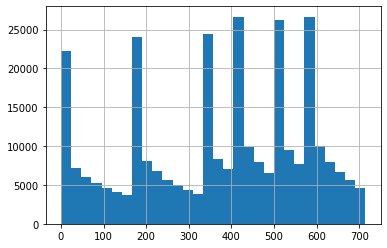

In [27]:
transcript.time.hist(bins=30)

**split the transcript value to amount, offer_id and reward**

In [28]:
transcript_value = pd.DataFrame([x for x in transcript['value']])
transcript_value.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


**For new columns, merge "offer id" and "offer_id"**

In [29]:
transcript_value.columns = transcript_value.columns.str.replace('offer id', 'offer_id')
s = transcript_value.stack()
transcript_value = s.unstack()
transcript_value.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [30]:
# check null values in each column
transcript_value.isnull().sum()/transcript_value.shape[0]

amount      0.546696
offer_id    0.453304
reward      0.890456
dtype: float64

**check the unique values of offer_id, they are the same as in portfolio**

In [31]:
transcript_value.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', nan], dtype=object)

**merge the split value columns back to transcript**

In [32]:
transcript = pd.concat([transcript,transcript_value], axis=1)
transcript.head()

,customer_id,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


## Split transcript to three tables:

- transcript_received for events: 'offer received'
- transcript_viewed for events: 'offer viewed'
- transcript_completed for events: 'offer completed'

### Create dataframe transcript_received for events: 'offer received'

In [33]:
transcript_received = transcript[transcript.event == 'offer received']
transcript_received.head()

,customer_id,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


**"amount" and reward are always missing in transcript_received, so I dropped the two columns**

In [34]:
transcript_received.isnull().sum()/transcript_received.shape[0]

customer_id    0.0
event          0.0
value          0.0
time           0.0
amount         1.0
offer_id       0.0
reward         1.0
dtype: float64

In [35]:
transcript_received = transcript_received.drop(['amount','reward','value'],axis=1)

**For a single customer id and offer id, check the duplicates**

In [36]:
transcript_received.groupby(['customer_id','offer_id']).event.count()\
           .reset_index().sort_values('event',ascending=False).head(10)

,customer_id,offer_id,event
11230,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,5
26995,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,5
16737,43a50d7e5c8547a9aa1ec31291b9fc30,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
8458,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,5
59098,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,5
30118,7a30763c05734cb3bd14123e1b6b9d63,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
43385,ad84e9ec3c33444c859e0295773bc05f,4d5c57ea9a6940dd891ad53e9dbe8da0,4
21592,57665306c0504df6a8f59dc3fcbfb888,f19421c1d4aa40978ebb69ca19b0e20d,4
4233,116b28e2983c44039eb8b20292742c94,5a8bc65990b245e5a138643cd4eb9837,4
14617,3b61ad3edcab45dd839f15e3fb1727e2,f19421c1d4aa40978ebb69ca19b0e20d,4


**Case study of one couple of (customer_id, offer_id), received multiple times**

For example:
- customer_id: '2ea50de315514ccaa5079db4c1ecbc0b'
- offer_id: 'fafdcd668e3743c1bb461111dcafc2a4'

In [37]:
transcript_received[(transcript_received.customer_id == '2ea50de315514ccaa5079db4c1ecbc0b') & 
                    (transcript_received.offer_id == 'fafdcd668e3743c1bb461111dcafc2a4')]

,customer_id,event,time,offer_id
58829,2ea50de315514ccaa5079db4c1ecbc0b,offer received,168,fafdcd668e3743c1bb461111dcafc2a4
116488,2ea50de315514ccaa5079db4c1ecbc0b,offer received,336,fafdcd668e3743c1bb461111dcafc2a4
156288,2ea50de315514ccaa5079db4c1ecbc0b,offer received,408,fafdcd668e3743c1bb461111dcafc2a4
207186,2ea50de315514ccaa5079db4c1ecbc0b,offer received,504,fafdcd668e3743c1bb461111dcafc2a4
250741,2ea50de315514ccaa5079db4c1ecbc0b,offer received,576,fafdcd668e3743c1bb461111dcafc2a4


In [38]:
transcript_received.groupby(['customer_id','offer_id']).event.count()\
           .reset_index().sort_values('event',ascending=False).tail(10)

,customer_id,offer_id,event
23294,5e6b3df1c36b4987a0707be5a5288ab2,3f207df678b143eea3cee63160fa8bed,1
23295,5e6b3df1c36b4987a0707be5a5288ab2,4d5c57ea9a6940dd891ad53e9dbe8da0,1
23296,5e6b3df1c36b4987a0707be5a5288ab2,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
23297,5e6b3df1c36b4987a0707be5a5288ab2,f19421c1d4aa40978ebb69ca19b0e20d,1
23298,5e729e38e6fb430188dee2aad9427200,2298d6c36e964ae4a3e7e9706d1fb8c2,1
23299,5e729e38e6fb430188dee2aad9427200,3f207df678b143eea3cee63160fa8bed,1
23300,5e78586d062041f1bfe97eacc63e1485,2298d6c36e964ae4a3e7e9706d1fb8c2,1
23301,5e78586d062041f1bfe97eacc63e1485,3f207df678b143eea3cee63160fa8bed,1
23302,5e78586d062041f1bfe97eacc63e1485,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
63287,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,1


**Case study of a single customer_id, received multiple offer_ids**

In [39]:
transcript_received[(transcript_received.customer_id == '5e78586d062041f1bfe97eacc63e1485')]

,customer_id,event,time,offer_id
12387,5e78586d062041f1bfe97eacc63e1485,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd
65593,5e78586d062041f1bfe97eacc63e1485,offer received,168,f19421c1d4aa40978ebb69ca19b0e20d
123266,5e78586d062041f1bfe97eacc63e1485,offer received,336,9b98b8c7a33c4b65b9aebfe6a799e6d9
214021,5e78586d062041f1bfe97eacc63e1485,offer received,504,2298d6c36e964ae4a3e7e9706d1fb8c2
257620,5e78586d062041f1bfe97eacc63e1485,offer received,576,3f207df678b143eea3cee63160fa8bed


In [40]:
# total customer_id received offers, 6 of customer ids did not receive any offer id.

transcript_received.customer_id.nunique()

16994

**Rename time to time_received in transcript_received**

In [41]:
transcript_received.rename(columns={'time':'time_received'}, inplace=True)

## Create dataframe transcript_viewed for events: 'offer viewed'

In [42]:
transcript_viewed = transcript[transcript.event == 'offer viewed']
print("size of offer viewed data: ", transcript_viewed.shape)
transcript_viewed.head()

size of offer viewed data:  (57725, 7)


,customer_id,event,value,time,amount,offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In [43]:
transcript_viewed.isnull().sum()/transcript_viewed.shape[0]

customer_id    0.0
event          0.0
value          0.0
time           0.0
amount         1.0
offer_id       0.0
reward         1.0
dtype: float64

**Drop columns with full null values and the value column in transcript_viewed**

In [44]:
transcript_viewed = transcript_viewed.drop(['amount','reward','value'],axis=1)\
                    .rename(columns={'time':'time_viewed'})

In [45]:
print("How many customer_ids viewed offers: ", transcript_viewed.customer_id.nunique())

How many customer_ids viewed offers:  16834


**Check multiple entries in transcript_viewed**

In [46]:
transcript_viewed.groupby(['customer_id','offer_id']).event.count()\
           .reset_index().sort_values('event',ascending=False).head(10)

,customer_id,offer_id,event
45829,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,5
20872,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,5
6528,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,5
8691,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,5
28015,91e68a13d7e5471cb53796d45b04f359,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
44517,e7757d0a16384143ad9b2f9e429c23a9,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
16723,57665306c0504df6a8f59dc3fcbfb888,f19421c1d4aa40978ebb69ca19b0e20d,4
40508,d2678b66cabe423390376ece655685c0,5a8bc65990b245e5a138643cd4eb9837,4
19818,67d07ddc731f420ead3ee2ff451b72ad,4d5c57ea9a6940dd891ad53e9dbe8da0,4
36491,bd07ab3268834809a97f173d156248e1,4d5c57ea9a6940dd891ad53e9dbe8da0,4


**Case study one, to better understand the transcript_viewed data, same ids but viewed at various time**

In [47]:
transcript_viewed[(transcript_viewed.customer_id == 'eece6a9a7bdd4ea1b0f812f34fc619d6') & 
                 (transcript_viewed.offer_id == '5a8bc65990b245e5a138643cd4eb9837')]

,customer_id,event,time_viewed,offer_id
40354,eece6a9a7bdd4ea1b0f812f34fc619d6,offer viewed,90,5a8bc65990b245e5a138643cd4eb9837
71255,eece6a9a7bdd4ea1b0f812f34fc619d6,offer viewed,174,5a8bc65990b245e5a138643cd4eb9837
170089,eece6a9a7bdd4ea1b0f812f34fc619d6,offer viewed,414,5a8bc65990b245e5a138643cd4eb9837
224082,eece6a9a7bdd4ea1b0f812f34fc619d6,offer viewed,516,5a8bc65990b245e5a138643cd4eb9837
260805,eece6a9a7bdd4ea1b0f812f34fc619d6,offer viewed,576,5a8bc65990b245e5a138643cd4eb9837


## Create dataframe transcript_trans for events: 'transaction'

In [48]:
transcript_trans = transcript[transcript.event == 'transaction']
print("size of offer transaction data: ", transcript_trans.shape)
transcript_trans.head()

size of offer transaction data:  (138953, 7)


,customer_id,event,value,time,amount,offer_id,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,NaN,NaN


In [49]:
transcript_trans.isnull().sum()/transcript_trans.shape[0]

customer_id    0.0
event          0.0
value          0.0
time           0.0
amount         0.0
offer_id       1.0
reward         1.0
dtype: float64

**Drop value, offer_id and reward in transcript_trans**.

In [50]:
transcript_trans = transcript_trans.drop(['value','offer_id', 'reward'], axis=1).rename(columns={'time':'time_trans'})

In [51]:
transcript_trans.groupby('customer_id').amount.sum().reset_index().sort_values('amount',ascending=False).head()

,customer_id,amount
3929,3c8d541112a74af99e88abbd0692f00e,1608.69
15693,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
11422,ae6f43089b674728a50b8727252d3305,1327.74
6366,626df8678e2a4953b9098246418c9cfa,1321.42
7492,73afdeca19e349b98f09e928644610f8,1319.97


## Create dataframe transcript_completed for events: 'offer completed'

- Remove columns which have null values
- Do case study for individual customer_id and offer_id with multiple entries
- Rename fields: 'time':'time_completed', 'reward':'reward_completed'

In [52]:
transcript_completed = transcript[transcript.event == 'offer completed']
print("size of offer completed data: ", transcript_completed.shape)
transcript_completed.head()

size of offer completed data:  (33579, 7)


,customer_id,event,value,time,amount,offer_id,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [53]:
transcript_completed.isnull().sum()/transcript_completed.shape[0]

customer_id    0.0
event          0.0
value          0.0
time           0.0
amount         1.0
offer_id       0.0
reward         0.0
dtype: float64

In [54]:
# drop two columns

transcript_completed = transcript_completed.drop(['value','amount'], axis=1)

In [55]:
transcript_completed.groupby(['customer_id','offer_id']).time.count().reset_index()\
         .sort_values('time',ascending=False).head(10)

,customer_id,offer_id,time
16864,948ec827ac334c8782a1da99a2d6a39b,ae264e3637204a6fb9bb56bc8210ddfd,4
3143,1c8cf4af93464dcaa971cfcffc2cc1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,4
26950,edc7b04392144da9979f3077095f268a,fafdcd668e3743c1bb461111dcafc2a4,4
7129,3ead7d94371041fcab4db5fb57ced95c,ae264e3637204a6fb9bb56bc8210ddfd,4
21558,bd2cdd691aca4bb0a0e039979ee5de5c,2298d6c36e964ae4a3e7e9706d1fb8c2,4
23894,d3209835a40a423fbf2c967218d00bcd,ae264e3637204a6fb9bb56bc8210ddfd,4
4385,281d463f31e74ecaa4451d169868c5d7,2298d6c36e964ae4a3e7e9706d1fb8c2,4
26272,e7757d0a16384143ad9b2f9e429c23a9,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
8278,487ad048c0e248a8bf6eb1545f5be4c6,2906b810c7d4411798c6938adc9daaa5,4
22793,c93f9619abd642a684bd79953cef992c,4d5c57ea9a6940dd891ad53e9dbe8da0,4


In [56]:
# case study:

transcript_completed[(transcript_completed.customer_id == '948ec827ac334c8782a1da99a2d6a39b') &
                    (transcript_completed.offer_id == 'ae264e3637204a6fb9bb56bc8210ddfd')]

,customer_id,event,time,offer_id,reward
28736,948ec827ac334c8782a1da99a2d6a39b,offer completed,42,ae264e3637204a6fb9bb56bc8210ddfd,10
88037,948ec827ac334c8782a1da99a2d6a39b,offer completed,222,ae264e3637204a6fb9bb56bc8210ddfd,10
146318,948ec827ac334c8782a1da99a2d6a39b,offer completed,390,ae264e3637204a6fb9bb56bc8210ddfd,10
172835,948ec827ac334c8782a1da99a2d6a39b,offer completed,420,ae264e3637204a6fb9bb56bc8210ddfd,10


In [57]:
transcript_completed.rename(columns={'time':'time_completed', 'reward':'reward_completed'}, inplace=True)

In [58]:
transcript_completed.head()

,customer_id,event,time_completed,offer_id,reward_completed
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10


## Merge Tables for EDA

- To get more information for the segmented data from transcript by events, I group the data by customer_ids and offer_ids, count the number of entries for each pair of (customer_id, offer_id)

- For offers received, there are total 63288 data points of (customer_id, offer_id)
- Among the received offers, 49135 of them were viewed, e.g., 77.6% of them were viewed. 
- 28996 of the offers were completed eventually, e.g., 45.5% of them were completed

**Group offer received events**

In [59]:
transcript_received = transcript_received.groupby(['event','customer_id','offer_id'])['time_received']\
                      .count().reset_index().rename(columns={'time_received':'received_count'})

transcript_received.shape

(63288, 4)

In [60]:
transcript_received.head(10)

,event,customer_id,offer_id,received_count
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
5,offer received,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2
6,offer received,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
7,offer received,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
8,offer received,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1
9,offer received,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1


**How many customer ids have offer received?**

In [61]:
transcript_received.customer_id.nunique()

16994

**How many times each customer received an offer?**

In [62]:
transcript_received.received_count.value_counts()

1    51570
2    10523
3     1124
4       66
5        5
Name: received_count, dtype: int64

**Group offer viewed events**

In [63]:
transcript_viewed = transcript_viewed.groupby(['event','customer_id','offer_id'])['time_viewed']\
                      .count().reset_index().rename(columns={'time_viewed':'viewed_count'})


transcript_viewed.shape

(49135, 4)

In [64]:
transcript_viewed.head(10)

,event,customer_id,offer_id,viewed_count
0,offer viewed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
1,offer viewed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
2,offer viewed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
3,offer viewed,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
4,offer viewed,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2
5,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
6,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1
7,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,1
8,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,1
9,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


**Calculate the viewed rate**

In [65]:
transcript_viewed.shape[0]/transcript_received.shape[0]

0.7763715080267981

**Group offer completed events**

In [66]:
transcript_completed = transcript_completed.groupby(['event','customer_id','offer_id','reward_completed'])['time_completed']\
                      .count().reset_index().rename(columns={'time_completed':'completed_count'})

transcript_completed.shape

(28996, 5)

In [67]:
transcript_completed.head(10)

,event,customer_id,offer_id,reward_completed,completed_count
0,offer completed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,1
1,offer completed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1
2,offer completed,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1
3,offer completed,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1
4,offer completed,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1
5,offer completed,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1
6,offer completed,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,1
7,offer completed,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,2.0,2
8,offer completed,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1
9,offer completed,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1


In [68]:
print("The completed rate for total received events:", transcript_completed.shape[0]/transcript_received.shape[0])
print("The completed rate for total viewed events:", transcript_completed.shape[0]/transcript_viewed.shape[0])

The completed rate for total received events: 0.4581595247124257
The completed rate for total viewed events: 0.5901292357789762


## Aggregate data together 


- Merge three tables above transcript_analysis for further EDA and data visualization.
- Join portfolio and profile information

In [69]:
transcript_analysis = transcript_received.merge(transcript_viewed, on = ['customer_id','offer_id'], how='left')


transcript_analysis = transcript_analysis.merge(transcript_completed, on = ['customer_id','offer_id'], how='left')
transcript_analysis.rename(columns={'event_x':'event_received','event_y':'event_viewed','event':'event_completed'}
                           ,inplace=True)
transcript_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,NaN,NaN,offer completed,2.0,1.0
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,NaN,NaN,NaN
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,NaN,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0


In [70]:
transcript_analysis.notnull().sum()/transcript_analysis.shape[0]

event_received      1.000000
customer_id         1.000000
offer_id            1.000000
received_count      1.000000
event_viewed        0.776372
viewed_count        0.776372
event_completed     0.458160
reward_completed    0.458160
completed_count     0.458160
dtype: float64

**Add portfolio and profile informatio**

In [71]:
transcript_analysis = transcript_analysis.merge(portfolio, on ='offer_id', how = 'left')
transcript_analysis = transcript_analysis.merge(profile, on='customer_id', how='left')

transcript_analysis.event_viewed.fillna("not viewed", inplace=True)
transcript_analysis.event_completed.fillna("not completed", inplace=True)

transcript_analysis.viewed_count.fillna(0, inplace=True)
transcript_analysis.completed_count.fillna(0, inplace=True)

transcript_analysis.head()

,event_received,customer_id,offer_id,received_count,event_viewed,viewed_count,event_completed,reward_completed,completed_count,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,not viewed,0.0,offer completed,2.0,1.0,2,10,7,discount,1,1,0,1,M,33,20170421,72000.0
1,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,offer viewed,1.0,not completed,NaN,0.0,0,0,4,informational,1,1,0,1,M,33,20170421,72000.0
2,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,offer viewed,1.0,not completed,NaN,0.0,0,0,3,informational,1,1,1,0,M,33,20170421,72000.0
3,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,offer viewed,1.0,offer completed,5.0,1.0,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.0
4,offer received,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,offer viewed,1.0,offer completed,2.0,1.0,2,10,10,discount,1,1,1,1,M,33,20170421,72000.0


# Data Visualization

## Distribution of viewed counts

- Most offers were viewed once (65.3%)
- Some were never viewed (22.4%)

Rate of viewed offers to total offers:
 1.0    0.652841
0.0    0.223628
2.0    0.112107
3.0    0.010713
4.0    0.000648
5.0    0.000063
Name: viewed_count, dtype: float64


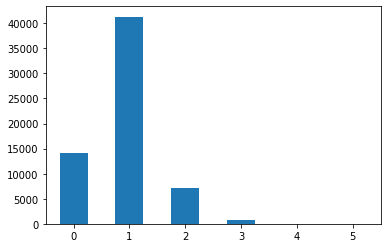

In [72]:
transcript_analysis.groupby('viewed_count').event_viewed.count().reset_index().event_viewed.plot.bar(rot=0)

print("Rate of viewed offers to total offers:\n", 
      transcript_analysis.viewed_count.value_counts()/transcript_analysis.shape[0])

## Distribution of completed offers

<AxesSubplot:>

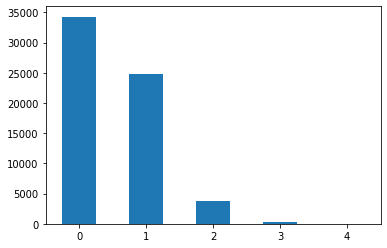

In [73]:
transcript_analysis.groupby('completed_count').event_completed.count().reset_index().event_completed.plot.bar(rot=0)

In [74]:
transcript_analysis['event'] = 'not viewed'
transcript_analysis['event'][transcript_analysis.event_viewed == 'offer viewed'] = 'viewed not completed'
transcript_analysis['event'][transcript_analysis.event_completed == 'offer completed'] = 'completed'

In [75]:
transcript_analysis.event.value_counts()

completed               28996
viewed not completed    24675
not viewed               9617
Name: event, dtype: int64

## Difficult Levels and Offers

### Viewed vs Not Viewed Offers: Segmented by Difficulty Levels

Average difficulty of received offers to be viewed:  7.231179403683728
Average difficulty of received offers not be viewed: 9.379354200522858


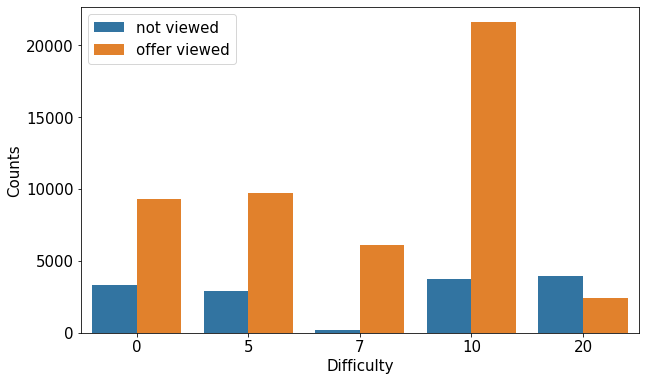

In [76]:
# Difficulty Levels: Viewed vs Not Viewed

difficulty_viewed = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed'].difficulty
difficulty_notviewed = transcript_analysis[transcript_analysis.event_viewed != 'offer viewed'].difficulty

print("Average difficulty of received offers to be viewed: ",difficulty_viewed.mean())
print("Average difficulty of received offers not be viewed:",difficulty_notviewed.mean())


fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="difficulty", hue='event_viewed',data=transcript_analysis)
plt.xlabel('Difficulty', fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
#ax.legend()
plt.show()

### Completed vs Viewed not completed vs Not Viewed Offers: Segmented by Difficulty Levels

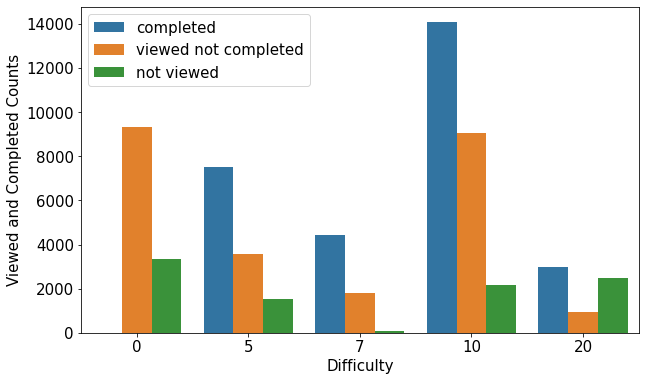

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="difficulty", hue='event',data=transcript_analysis)
plt.xlabel('Difficulty', fontsize=15)
plt.ylabel("Viewed and Completed Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc = 2,prop={'size': 15})
plt.show()

## Offers viewed ratio and Completed Ratio: Segmented by Difficulty Levels

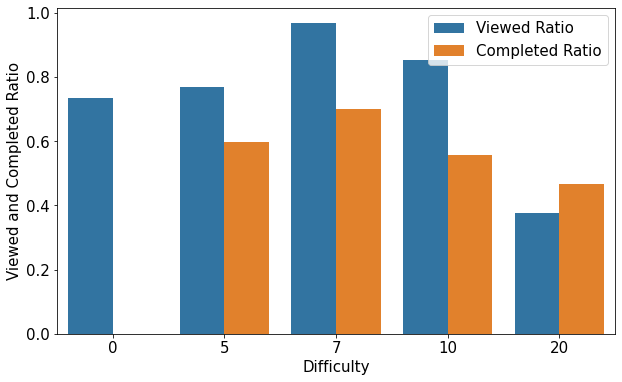

In [78]:
# Viewed Rate segmented by Difficult Levels

df_temp1 = transcript_analysis.groupby(['difficulty'])['event_received'].count().reset_index()

df_temp2 = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed']\
           .groupby(['difficulty'])['event_viewed'].count().reset_index()


df_temp3 = transcript_analysis[transcript_analysis.event_completed == 'offer completed']\
           .groupby(['difficulty'])['event_completed'].count().reset_index()


df_difficulty = df_temp1.merge(df_temp2, on ='difficulty')
df_difficulty = df_difficulty.merge(df_temp3, on = 'difficulty', how='left')

df_difficulty['Viewed Ratio'] = df_difficulty['event_viewed']/df_difficulty['event_received']
df_difficulty['Completed Ratio'] = df_difficulty['event_completed']/df_difficulty['event_received']

df_difficulty = df_difficulty[['difficulty','Viewed Ratio','Completed Ratio']].melt(id_vars='difficulty')\
                .rename(columns=str.title)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Difficulty', y = 'Value', hue='Variable',data = df_difficulty)
plt.xlabel('Difficulty', fontsize=15)
plt.ylabel("Viewed and Completed Ratio",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Duration and Offers

### Viewed vs Not Viewed Offers: Segmented by Duration Values

Average duration of received offers to be viewed:  6.34191513177979
Average duration of received offers not be viewed: 7.070373772345086


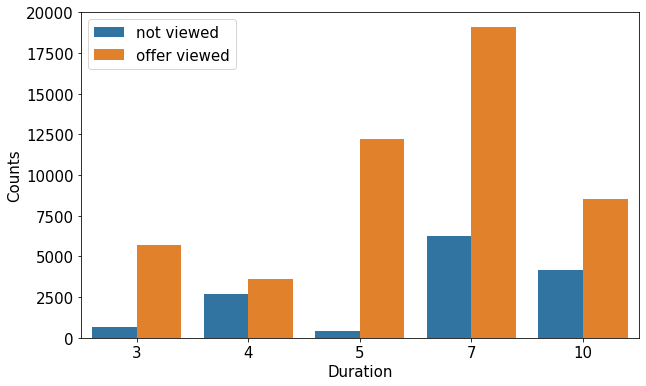

In [79]:
# Durations: Viewed vs Not Viewed

duration_viewed = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed'].duration
duration_notviewed = transcript_analysis[transcript_analysis.event_viewed != 'offer viewed'].duration

print("Average duration of received offers to be viewed: ", duration_viewed.mean())
print("Average duration of received offers not be viewed:", duration_notviewed.mean())


fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="duration", hue='event_viewed',data=transcript_analysis)
plt.xlabel('Duration', fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
#ax.legend()
plt.show()

### Completed vs Viewed not completed vs Not Viewed Offers: Segmented by Duration Values

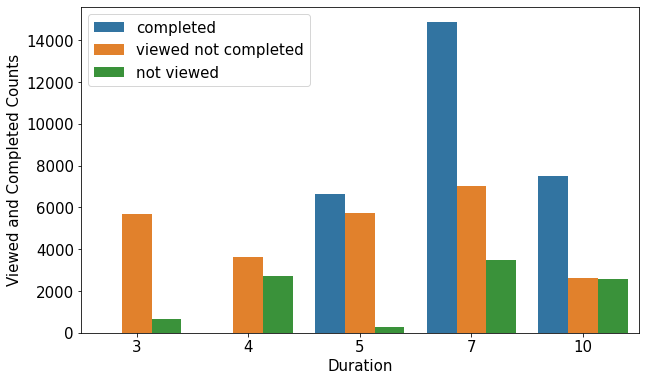

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="duration", hue='event',data=transcript_analysis)
plt.xlabel('Duration', fontsize=15)
plt.ylabel("Viewed and Completed Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc = 2,prop={'size': 15})
plt.show()

## Offers viewed ratio and Completed Ratio: Segmented by Duration Values

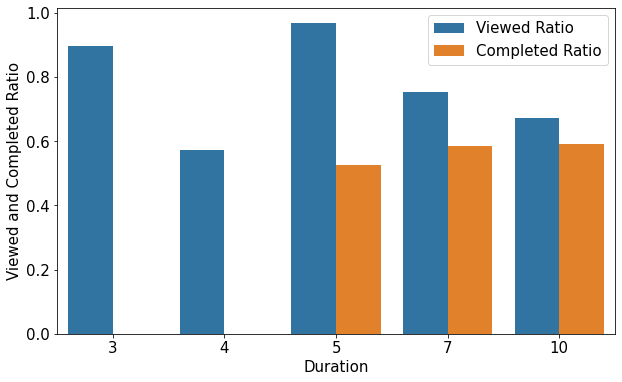

In [81]:
# Viewed Rate segmented by Durations

df_temp1 = transcript_analysis.groupby(['duration'])['event_received'].count().reset_index()

df_temp2 = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed']\
           .groupby(['duration'])['event_viewed'].count().reset_index()


df_temp3 = transcript_analysis[transcript_analysis.event_completed == 'offer completed']\
           .groupby(['duration'])['event_completed'].count().reset_index()


df_duration = df_temp1.merge(df_temp2, on ='duration')
df_duration = df_duration.merge(df_temp3, on = 'duration', how='left')

df_duration['Viewed Ratio'] = df_duration['event_viewed']/df_duration['event_received']
df_duration['Completed Ratio'] = df_duration['event_completed']/df_duration['event_received']

df_duration = df_duration[['duration','Viewed Ratio','Completed Ratio']].melt(id_vars='duration')\
                .rename(columns=str.title)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Duration', y = 'Value', hue='Variable',data = df_duration)
plt.xlabel('Duration', fontsize=15)
plt.ylabel("Viewed and Completed Ratio",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Offer Types and Offers

### Viewed vs Not Viewed Offers: Segmented by Offer Types

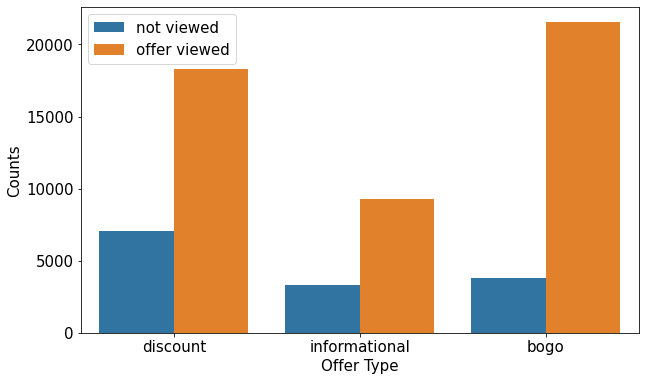

In [82]:
# Offer Types: Viewed vs Not Viewed

offer_viewed = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed'].offer_type
offer_notviewed = transcript_analysis[transcript_analysis.event_viewed != 'offer viewed'].offer_type

fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="offer_type", hue='event_viewed',data=transcript_analysis)
plt.xlabel('Offer Type', fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
#ax.legend()
plt.show()

### Completed vs Viewed not completed vs Not Viewed Offers: Segmented by Offer Types

Interestingly, informational offers never were completed

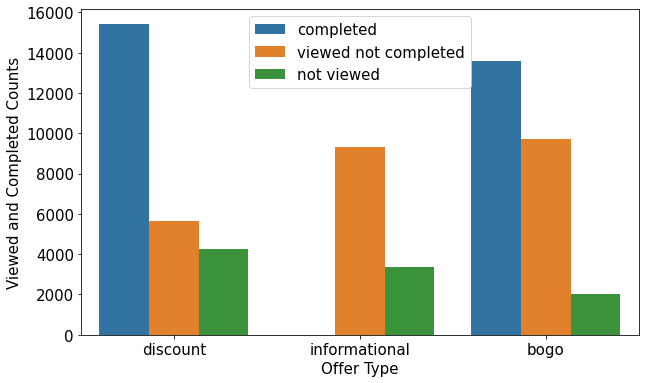

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="offer_type", hue='event',data=transcript_analysis)
plt.xlabel('Offer Type', fontsize=15)
plt.ylabel("Viewed and Completed Counts",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc = 'upper center',prop={'size': 15})
plt.show()

### Offers viewed ratio and Completed Ratio: Segmented by Offer Types

Informational offers never were completed

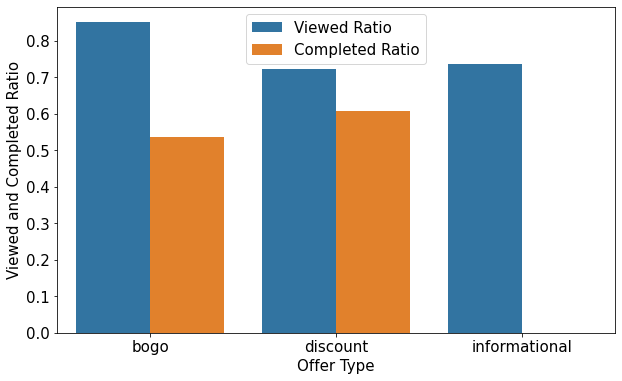

In [84]:
# Viewed Rate segmented by Offer Types

df_temp1 = transcript_analysis.groupby(['offer_type'])['event_received'].count().reset_index()

df_temp2 = transcript_analysis[transcript_analysis.event_viewed == 'offer viewed']\
           .groupby(['offer_type'])['event_viewed'].count().reset_index()


df_temp3 = transcript_analysis[transcript_analysis.event_completed == 'offer completed']\
           .groupby(['offer_type'])['event_completed'].count().reset_index()


df_offer_type = df_temp1.merge(df_temp2, on ='offer_type')
df_offer_type = df_offer_type.merge(df_temp3, on = 'offer_type', how='left')

df_offer_type['Viewed Ratio'] = df_offer_type['event_viewed']/df_offer_type['event_received']
df_offer_type['Completed Ratio'] = df_offer_type['event_completed']/df_offer_type['event_received']

df_offer_type = df_offer_type[['offer_type','Viewed Ratio','Completed Ratio']].melt(id_vars='offer_type')\
                .rename(columns=str.title)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Offer_Type', y = 'Value', hue='Variable',data = df_offer_type)
plt.xlabel('Offer Type', fontsize=15)
plt.ylabel("Viewed and Completed Ratio",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Member Experience for Customers and Offer Acceptance

- Need to create new dataframes:
  1. transcript_received2
  2. transcript_viewed2
  3. transcript_completed2
  
  They are similar as transcript_received, transcript_viewed and transcript_completed in above analysis, by group not by both customer_ids and offer_ids, but just by customer ids.

- Add a new column in transcript_analysis as how long (in days) each membership has been kept
- Add a new column in which year each one became a member

In [85]:
transcript_analysis['became_member_on'] = \
      pd.to_datetime(transcript_analysis.became_member_on.apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:]))


transcript_analysis['member_days']  = datetime.datetime.today().date()  - transcript_analysis['became_member_on'].dt.date
transcript_analysis['member_days'] = transcript_analysis['member_days'].dt.days
transcript_analysis['member_year'] = transcript_analysis['became_member_on'].dt.year

**There are 16994 customers received one or more offers**

In [86]:
transcript_received2 = transcript_received.groupby(['customer_id'])['offer_id'].count()\
                       .reset_index().rename(columns={'offer_id':'offer_received'})

transcript_received2.shape

(16994, 2)

**And 16834 customers viewed one or more offers**

In [87]:
transcript_viewed2 = transcript_viewed.groupby(['customer_id'])['offer_id']\
                      .count().reset_index().rename(columns={'offer_id':'offer_viewed'})

transcript_viewed2.shape

(16834, 2)

**And 12774 of them completed one or more offer**

In [88]:
transcript_completed2 = transcript_completed.groupby(['customer_id'])['offer_id']\
                        .count().reset_index().rename(columns={'offer_id':'offer_completed'})

transcript_completed2.shape

(12774, 2)

**Join the above three tables**

In [89]:
transcript_customers = transcript_received2.merge(transcript_viewed2, on = 'customer_id', how='left')
transcript_customers = transcript_customers.merge(transcript_completed2, on = 'customer_id', how='left')
transcript_customers = transcript_customers.merge(profile, on = 'customer_id', how='left')
transcript_customers.head()

,customer_id,offer_received,offer_viewed,offer_completed,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,5,4.0,3.0,M,33,20170421,72000.0
1,00116118485d4dfda04fdbaba9a87b5c,1,1.0,NaN,None,118,20180425,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,5,5.0,3.0,O,40,20180109,57000.0
3,0020c2b971eb4e9188eac86d93036a77,4,3.0,2.0,F,59,20160304,90000.0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,4.0,3.0,F,24,20161111,60000.0


**Convert member information to merbership duration (in days)**

In [90]:
transcript_customers['became_member_on'] = \
      pd.to_datetime(transcript_customers.became_member_on.apply(lambda x: str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:]))


transcript_customers['member_days']  = datetime.datetime.today().date()  - transcript_customers['became_member_on'].dt.date
transcript_customers['member_days'] = transcript_customers['member_days'].dt.days

In [91]:
# check null vlaues in transcript_customers

transcript_customers.notnull().sum()/transcript_customers.shape[0]

customer_id         1.000000
offer_received      1.000000
offer_viewed        0.990585
offer_completed     0.751677
gender              0.872072
age                 1.000000
became_member_on    1.000000
income              0.872072
member_days         1.000000
dtype: float64

**Remove outliers: age=118**

In [92]:
transcript_customers = transcript_customers[transcript_customers.age != 118].reset_index(drop=True)

## Customer Ages and Offers

- Check the distribution of offer acceptance/completeness and ages
- More young people did not complete any offers

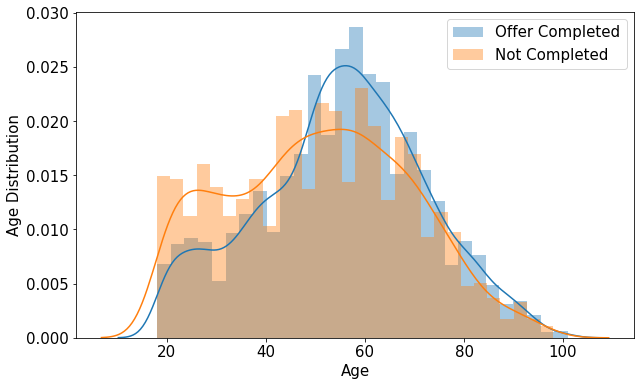

In [93]:
transcript_customers_completed = transcript_customers[transcript_customers.offer_completed.notnull()]
transcript_customers_notcompleted = transcript_customers[transcript_customers.offer_completed.isnull()]

age_completed = transcript_customers_completed.age
age_notcompleted = transcript_customers_notcompleted.age

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(age_completed, bins=30, label='Offer Completed',ax=ax)
sns.distplot(age_notcompleted, bins=30, label='Not Completed',ax=ax)
plt.xlabel('Age', fontsize=15)
plt.ylabel("Age Distribution",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Customer Income and Offers

- Check the distribution of offer acceptance/completeness correlated with customer income
- People with higher salaries intended to complete offers
- More people with lower salaries (<60,000) did not complete any offers

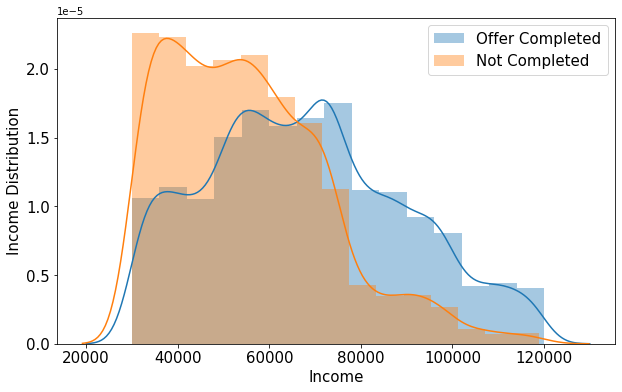

In [94]:
income_completed = transcript_customers_completed.income
income_notcompleted = transcript_customers_notcompleted.income

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(income_completed, bins=15, label='Offer Completed',ax=ax)
sns.distplot(income_notcompleted, bins=15, label='Not Completed',ax=ax)
plt.xlabel('Income', fontsize=15)
plt.ylabel("Income Distribution",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Customer Membership Duration and Offers

- New members with membership less than 1200 days (today - the first membership day) did not accept any offer

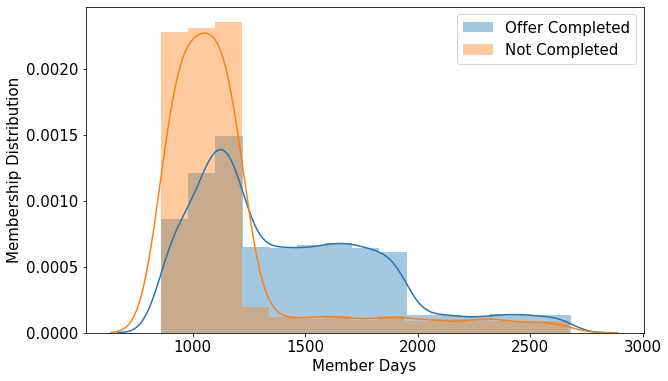

In [95]:
days_completed = transcript_customers_completed.member_days
days_notcompleted = transcript_customers_notcompleted.member_days

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(days_completed, bins=15, label='Offer Completed',ax=ax)
sns.distplot(days_notcompleted, bins=15, label='Not Completed',ax=ax)
plt.xlabel('Member Days', fontsize=15)
plt.ylabel("Membership Distribution",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

## Gender and Offers

- Completed Ratio is divided in three parts: female, male, and 'O'
- Not Completed Ratio is also divided in three parts: female, male, and 'O'
- More males did not complete any offers: 72.9% of people who did not complete any offers were males

In [96]:
transcript_customers_gender = transcript_customers_completed.groupby('gender')['customer_id']\
                              .count().reset_index().rename(columns={'customer_id':'Completed Ratio'})
transcript_customers_gender['Completed Ratio'] /= transcript_customers_completed.shape[0]

transcript_customers_gender2 = transcript_customers_notcompleted.groupby('gender')['customer_id']\
                              .count().reset_index().rename(columns={'customer_id':'Not Completed'})

transcript_customers_gender2['Not Completed'] /= transcript_customers_notcompleted.shape[0]

transcript_customers_gender = transcript_customers_gender.merge(transcript_customers_gender2, 
                                                                on = 'gender', how='left')

transcript_customers_gender = transcript_customers_gender.melt(id_vars='gender').rename(columns=str.title)
transcript_customers_gender

,Gender,Variable,Value
0,F,Completed Ratio,0.449775
1,M,Completed Ratio,0.535291
2,O,Completed Ratio,0.014934
3,F,Not Completed,0.258998
4,M,Not Completed,0.729358
5,O,Not Completed,0.011644


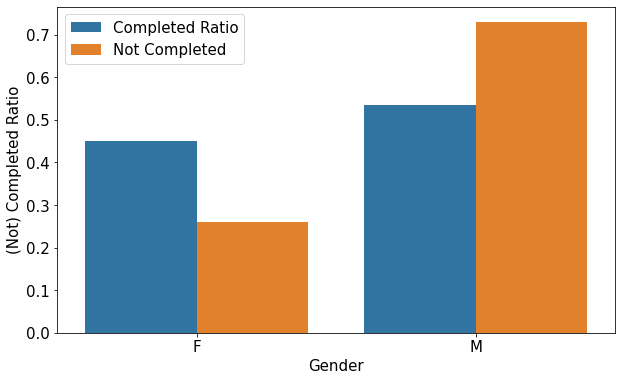

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Gender', y='Value', hue='Variable', 
            data=transcript_customers_gender[transcript_customers_gender.Gender!='O'])
plt.xlabel('Gender', fontsize=15)
plt.ylabel("(Not) Completed Ratio",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

# Machine Learning Modeling for Classification

I would like to predict if an sent offer can be completed or not. This is a supervised classification problem. 

## Prepare the data

- The data is from the aggregated data before: the transcript_analysis dataframe
- df_model collects all fields needed for training (training data)
- gender/income with null values removed
- Label data: offer complete, convert it to binary values (0 and 1)
- Encode categorical fields
- Split the data to training and testing sets

In [98]:
df_model = transcript_analysis[['received_count','difficulty','duration','offer_type','reward',
                                'email','mobile','social','web','age','gender','income',
                                'member_year','member_days', 'event_completed']]
df_model.isnull().sum()

received_count        0
difficulty            0
duration              0
offer_type            0
reward                0
email                 0
mobile                0
social                0
web                   0
age                   0
gender             8066
income             8066
member_year           0
member_days           0
event_completed       0
dtype: int64

In [99]:
df_model.head()

,received_count,difficulty,duration,offer_type,reward,email,mobile,social,web,age,gender,income,member_year,member_days,event_completed
0,1,10,7,discount,2,1,1,0,1,33,M,72000.0,2017,1318,offer completed
1,1,0,4,informational,0,1,1,0,1,33,M,72000.0,2017,1318,not completed
2,1,0,3,informational,0,1,1,1,0,33,M,72000.0,2017,1318,not completed
3,1,5,5,bogo,5,1,1,1,1,33,M,72000.0,2017,1318,offer completed
4,1,10,10,discount,2,1,1,1,1,33,M,72000.0,2017,1318,offer completed


In [100]:
df_model = df_model[df_model.gender.notnull()].reset_index(drop=True)

df_model.shape

(55222, 15)

**Convert labels to binary values**

In [101]:
df_model['event_completed'] = df_model.event_completed.apply(lambda x: 1 if x=='offer completed' else 0)

**Set up features and labels for classification modeling**

In [102]:
features = df_model.drop('event_completed', axis=1)
labels = df_model.event_completed

In [103]:
labels.value_counts()

1    27942
0    27280
Name: event_completed, dtype: int64

### Encode categorical fields

In [104]:
features.dtypes

received_count      int64
difficulty          int64
duration            int64
offer_type         object
reward              int64
email               int64
mobile              int64
social              int64
web                 int64
age                 int64
gender             object
income            float64
member_year         int64
member_days         int64
dtype: object

**Create new features offer_type_encode and gender_encode to replace the original two fields offer_type and gender**

In [105]:
encoder = LabelEncoder()

encoder.fit(features['offer_type'])
features['offer_type_encode'] = encoder.transform(features['offer_type'])

In [106]:
encoder.fit(features['gender'])
features['gender_encode'] = encoder.transform(features['gender'])

In [107]:
features_encode = features.drop(['offer_type','gender'], axis=1)
features_encode.head()

,received_count,difficulty,duration,reward,email,mobile,social,web,age,income,member_year,member_days,offer_type_encode,gender_encode
0,1,10,7,2,1,1,0,1,33,72000.0,2017,1318,1,1
1,1,0,4,0,1,1,0,1,33,72000.0,2017,1318,2,1
2,1,0,3,0,1,1,1,0,33,72000.0,2017,1318,2,1
3,1,5,5,5,1,1,1,1,33,72000.0,2017,1318,0,1
4,1,10,10,2,1,1,1,1,33,72000.0,2017,1318,1,1


### Split the data to training and testing datasets

In [108]:
X_train, X_test, y_train, y_test = train_test_split(features_encode, labels, test_size=0.2, random_state=42)

In [109]:
X_train

,received_count,difficulty,duration,reward,email,mobile,social,web,age,income,member_year,member_days,offer_type_encode,gender_encode
29053,1,10,5,10,1,1,1,1,83,43000.0,2017,1136,0,1
2524,1,10,5,10,1,1,1,1,22,33000.0,2018,911,0,1
53548,1,5,7,5,1,1,0,1,67,96000.0,2016,1551,0,0
24001,2,10,7,10,1,1,1,0,46,42000.0,2018,1012,0,1
28540,1,0,4,0,1,1,0,1,58,109000.0,2016,1680,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,1,10,7,2,1,1,0,1,83,40000.0,2018,935,1,1
54343,2,5,7,5,1,1,0,1,55,54000.0,2016,1669,0,0
38158,1,5,7,5,1,1,0,1,65,103000.0,2015,1911,0,0
860,3,20,10,5,1,0,0,1,41,56000.0,2017,1123,1,1


**Shape of training and testing datasets**

In [110]:
print("Training Features Shape: ", X_train.shape)
print("Training Labels Shape: ", y_train.shape)
print("Testing Features Shape: ", X_test.shape)
print("Testing Labels Shape: ", y_test.shape)

Training Features Shape:  (44177, 14)
Training Labels Shape:  (44177,)
Testing Features Shape:  (11045, 14)
Testing Labels Shape:  (11045,)


## Baseline Model: Logistic Regression

- Logistic regression without parameter tuning is the first try to build the baseline model for this classification problem. 
- classification_report output the model accuracy, and the confusion matrix is visualized

In [111]:
model = linear_model.LogisticRegressionCV()

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

**Prediction and Model accuracy**

In [112]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      5453
           1       0.70      0.73      0.72      5592

   micro avg       0.71      0.71      0.71     11045
   macro avg       0.71      0.71      0.71     11045
weighted avg       0.71      0.71      0.71     11045

ROC score:  0.708079063328792


**Confusion Matrix visualization**

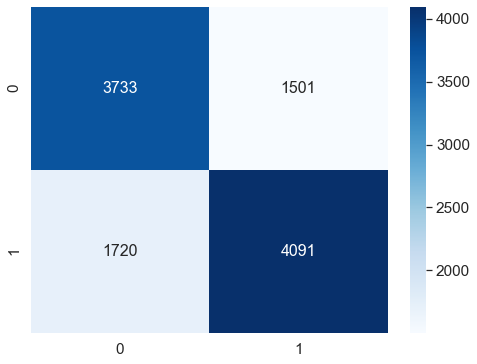

In [113]:
cm = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

## Random Forest Classifier

- Model accuracy is better than Logistic Regression

In [114]:
model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [115]:
print(classification_report(y_test, y_pred))
print("ROC score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5453
           1       0.77      0.74      0.76      5592

   micro avg       0.76      0.76      0.76     11045
   macro avg       0.76      0.76      0.76     11045
weighted avg       0.76      0.76      0.76     11045

ROC score:  0.7558656566308476


## Elaborate Modeling

- Scale data to 0 and 1
- Test a series of models

In [116]:
scaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(features_encode)
features_encode = scaler.transform(features_encode)

X_train, X_test, y_train, y_test = train_test_split(features_encode, labels, test_size=0.2, random_state=42)

In [117]:
model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      5453
           1       0.77      0.74      0.76      5592

   micro avg       0.76      0.76      0.76     11045
   macro avg       0.76      0.76      0.76     11045
weighted avg       0.76      0.76      0.76     11045

ROC score:  0.7578231109806338


In [118]:
#param_grid = { 
    #'bootstrap': [True],
    #'n_estimators': [100, 200, 300],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth': [3, 5, 10],
    #'criterion' :['gini', 'entropy']
#}

# Create a based model
#rf = ensemble.RandomForestClassifier()
# Instantiate the grid search model
#clf  = GridSearchCV(rf, cv=5, param_grid = param_grid)
#clf.fit(X_train, y_train)

**Machine Learning Algorithm Selection and Initialization**

In [119]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    XGBClassifier(),
    LGBMClassifier()
    ]

In [120]:
for model in MLA:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(type(model).__name__)
    print(classification_report(y_test, y_pred))
    print("ROC score: ", roc_auc_score(y_test, y_pred))

AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      5453
           1       0.77      0.81      0.79      5592

   micro avg       0.78      0.78      0.78     11045
   macro avg       0.78      0.78      0.78     11045
weighted avg       0.78      0.78      0.78     11045

ROC score:  0.7792912748740898
BaggingClassifier
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5453
           1       0.78      0.75      0.76      5592

   micro avg       0.76      0.76      0.76     11045
   macro avg       0.76      0.76      0.76     11045
weighted avg       0.76      0.76      0.76     11045

ROC score:  0.7630751877075709
ExtraTreesClassifier
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      5453
           1       0.76      0.74      0.75      5592

   micro avg       0.75      0.75      0.75     11045
   macro

**From the above tests I choose XGBoost Classifer**

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      5453
           1       0.78      0.83      0.80      5592

   micro avg       0.80      0.80      0.80     11045
   macro avg       0.80      0.80      0.80     11045
weighted avg       0.80      0.80      0.80     11045



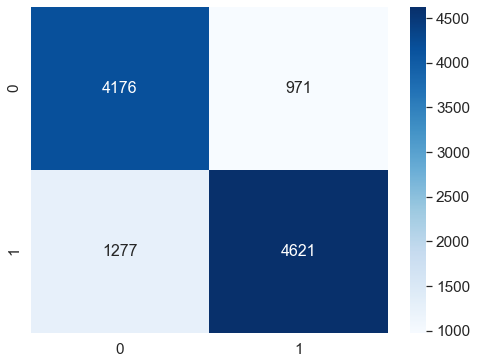

In [121]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

## Feature Importance Analysis

**Feature Importance for XGBoost Classifer**

In [122]:
feature_names = list(df_model.drop('event_completed',axis=1).columns)
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})\
                      .sort_values('importance', ascending=False)
feature_importances

,feature,importance
1,difficulty,0.688709
3,offer_type,0.061097
6,mobile,0.047356
11,income,0.042642
0,received_count,0.041765
13,member_days,0.038807
9,age,0.026903
8,web,0.013597
2,duration,0.011801
10,gender,0.009321


**Make a horizontal bar chart of feature importances**


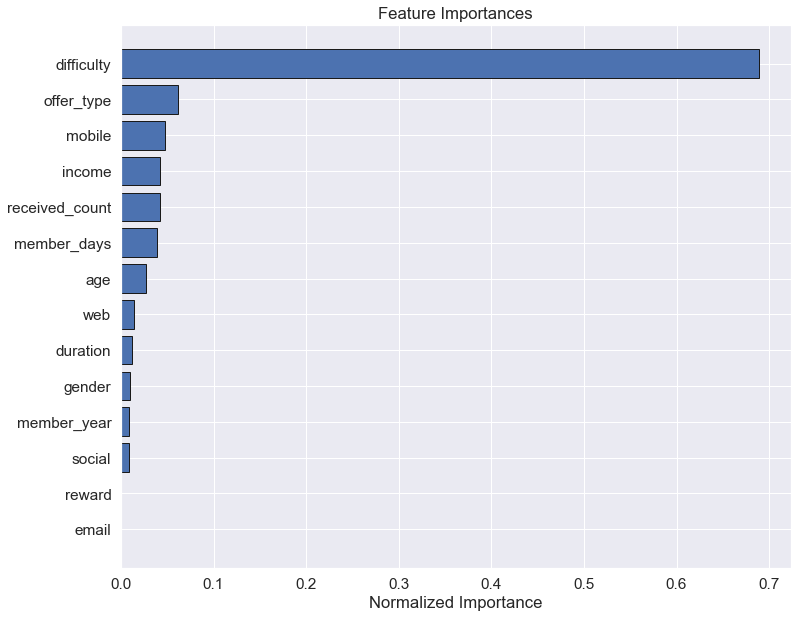

In [123]:
# Make a horizontal bar chart of feature importances
plt.figure(figsize = (12, 10))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(feature_importances.feature)[::-1], 
        feature_importances['importance'][::-1], 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks((list(feature_importances.feature)))
ax.set_yticklabels(feature_importances['feature'])

# Plot labeling
plt.xlabel('Normalized Importance')
plt.title('Feature Importances')
plt.show()

**Feature Importance for LightGBM Classifer**

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      5453
           1       0.78      0.81      0.79      5592

   micro avg       0.79      0.79      0.79     11045
   macro avg       0.79      0.79      0.79     11045
weighted avg       0.79      0.79      0.79     11045



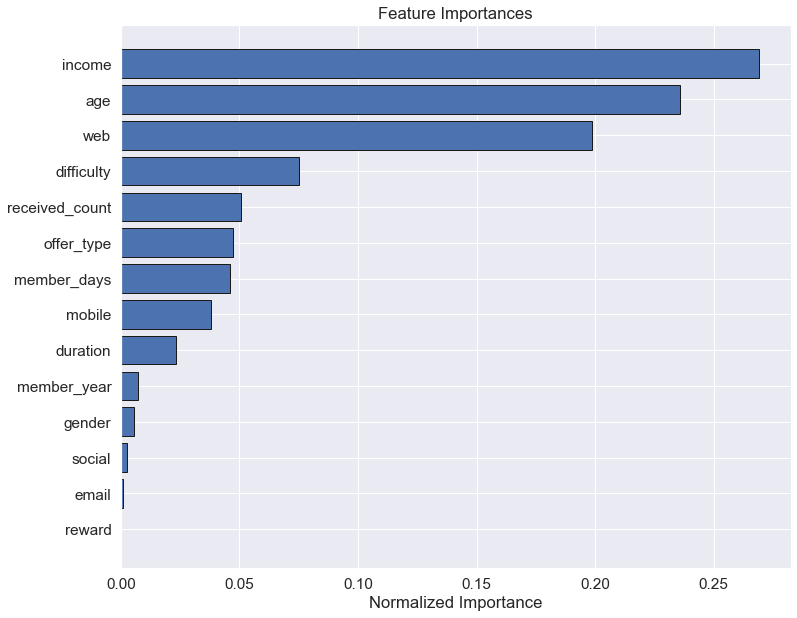

In [124]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

feature_names = list(df_model.drop('event_completed',axis=1).columns)
feature_importances2 = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})\
                      .sort_values('importance', ascending=False)

feature_importances2.importance /= feature_importances2.importance.sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (12, 10))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(feature_importances2.feature)[::-1], 
        feature_importances2['importance'][::-1], 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks((list(feature_importances2.feature)))
ax.set_yticklabels(feature_importances2['feature'])

# Plot labeling
plt.xlabel('Normalized Importance')
plt.title('Feature Importances')
plt.show()

**Mix two models and have normalized feature importance**

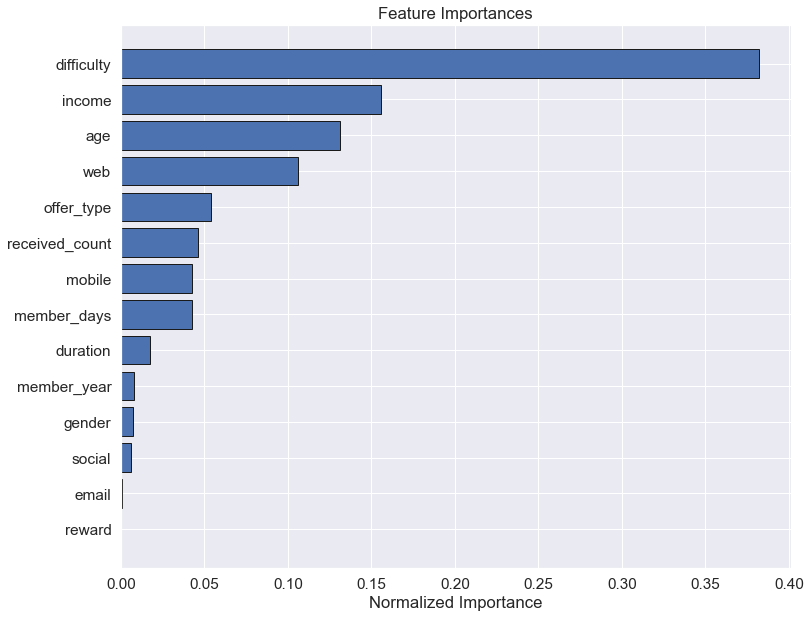

In [125]:
feature_importances = feature_importances.merge(feature_importances2, on = 'feature')
feature_importances['normalized_importance'] = (feature_importances.importance_x + feature_importances.importance_y)/2
feature_importances = feature_importances.sort_values('normalized_importance', ascending=False)

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (12, 10))
ax = plt.subplot()

# Need to reverse the index to plot most important on top
ax.barh(list(feature_importances.feature)[::-1], 
        feature_importances['normalized_importance'][::-1], 
        align = 'center', edgecolor = 'k')

# Set the yticks and labels
ax.set_yticks((list(feature_importances.feature)))
ax.set_yticklabels(feature_importances['feature'])

# Plot labeling
plt.xlabel('Normalized Importance')
plt.title('Feature Importances')
plt.show()

### Still XGBoost, with Grid Search and Cross Validation

In [126]:
param_grid  = {
    'max_depth': [2,6,10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.03, 0.1, 0.3]
}

In [127]:
# Create a based model

param_grid  = {
    'max_depth': [2,6,10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.03, 0.1, 0.3]
}

model = XGBClassifier()
clf  = GridSearchCV(model, cv=5, param_grid = param_grid)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 6, 10], 'n_estimators': [50, 100, 200], 'learning_rate': [0.03, 0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Final Model Accuracy for Testing Dataset**

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      5453
           1       0.79      0.83      0.81      5592

   micro avg       0.80      0.80      0.80     11045
   macro avg       0.80      0.80      0.80     11045
weighted avg       0.80      0.80      0.80     11045



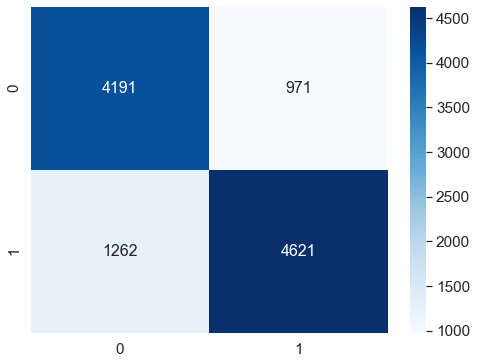

In [128]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_pred, y_test)

print(classification_report(y_test, y_pred))

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap="Blues",  fmt='g')# font size

plt.show()

**Model Accuracy for Training Dataset**

In [129]:
y_pred_train = clf.predict(X_train)
print(classification_report(y_pred_train , y_train))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     20466
           1       0.90      0.85      0.88     23711

   micro avg       0.87      0.87      0.87     44177
   macro avg       0.87      0.87      0.87     44177
weighted avg       0.87      0.87      0.87     44177

